In [1]:
import time
start_notebook_time = time.time()

In [2]:
import sklearn.linear_model
from sklearn.datasets import fetch_openml
import sys
import numpy as np

In [3]:
mnist = fetch_openml('mnist_784', version=1)

/Users/zivlazarov/miniforge3/envs/tensorflow-env/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
y = y.apply(lambda x : int(x))

In [6]:
X, y = X.to_numpy(), y.to_numpy()

In [7]:
X = np.concatenate((np.ones(shape=(X.shape[0],))[:, np.newaxis], X), axis=1)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def accuracy(predictions, y_test):
    return np.sum(predictions == y_test) / len(y_test)


def metrics(class_idx, X_test, y_test, model):
    if class_idx == -1:
        predictions = model.predict(X_test)
        confusion_matrix = np.zeros(shape=(model.num_classes, model.num_classes))
        # calculating the confusion matrix
        for idx in range(len(y_test)):
            y_test_idx = y_test[idx]
            preds_idx = predictions[idx]
            confusion_matrix[y_test_idx, preds_idx] += 1

        model_accuracy = accuracy(predictions, y_test)

        return confusion_matrix, model_accuracy

    else:
        class_sign_y = np.ones(shape=(len(y_test),))
        class_sign_y[np.where(y_test != model.classes[class_idx])] = -1

        predictions = np.sign(X_test.dot(model.weights[class_idx]))

        # predicted class_idx correctly
        tp = len(class_sign_y[(class_sign_y == predictions) & (class_sign_y == 1)])
        # predicted not class_idx correctly
        tn = len(class_sign_y[(class_sign_y == predictions) & (class_sign_y == -1)])
        # predicted class_idx incorrectly
        fp = len(class_sign_y[(class_sign_y != predictions) & (class_sign_y == -1)])
        # predicted not class_idx incorrectly
        fn = len(class_sign_y[(class_sign_y != predictions) & (class_sign_y == 1)])

        model_accuracy = (tp + tn) / len(y_test)
        sensitivity = tp / (tp + fn)
        selectivity = tn / (tn + fp)

        confusion_matrix = np.zeros(shape=(2, 2))
        confusion_matrix[0, 0] = tp
        confusion_matrix[0, 1] = fn
        confusion_matrix[1, 0] = fp
        confusion_matrix[1, 1] = tn

        return confusion_matrix, model_accuracy, sensitivity, selectivity

In [10]:
def visualize_metrics(class_idx, X_test, y_test, model, model_name):
    if class_idx == -1:
        predictions = model.predict(X_test)
        confusion_matrix, accuracy = metrics(-1, X_test, y_test, model)
        # displaying the confusion matrix with a heatmap
        sns.heatmap(confusion_matrix, annot=True, fmt='.4g')
        plt.ylabel('Y True')
        plt.xlabel('Y Pred')
        plt.title(
            f'Multi Class {model_name} Confusion Matrix\nAccuracy: {round(np.sum(predictions == y_test) / len(y_test), 3)}')
    else:
        # creating the grid for the classes
        fig, ax = plt.subplots(model.num_classes // 2, 2, figsize=(10, 10), constrained_layout=True)
        # fig.tight_layout()
        for i in range(model.num_classes):
            confusion_matrix, accuracy, sensitivity, selectivity = metrics(i, X_test, y_test, model)

            sns.heatmap(confusion_matrix, ax=ax[i // 2, i % 2], annot=True, fmt='.4g')
            ax[i // 2, i % 2].set_title(f'Confusion Matrix for Class {model.classes[i]}\n' + \
                                        f'Acc: {round(accuracy, 3)} | Sen: {round(sensitivity, 3)} | Sel: {round(selectivity, 3)}')
            ax[i // 2, i % 2].set_ylabel('Y True')
            ax[i // 2, i % 2].set_xlabel('Y Pred')
    plt.show()

In [47]:
def softmax(s):
    # normalize values to avoid over/underflow of the values (s can't be the zero vector)
    mean = np.mean(s, keepdims=True)
    std = np.std(s, keepdims=True)
    z = (s - mean) / std
    # max = np.max(s, keepdims=True)
    # min = np.min(s, keepdims=True)
    # z = (s - min) / (max - min)
    z = np.exp(z)
    return z / np.sum(z, axis=0)


class BaseRegressor:

    def __init__(self, num_features, classes, learning_rate=0.01, epochs=1):
        # num_features includes the extra bias column with the dataset so we'll add it
        self.num_features = num_features
        # values of the multi-class labels
        self.classes = classes
        self.num_classes = len(self.classes)
        self.num_samples = 0
        self.epochs = epochs

        # initializing the weights vectors for every class with values [-1, 1]
        self.weights = np.random.uniform(low=-1, high=1, size=(self.num_classes, self.num_features))
        # determined by the size of samples
        self.labels = None
        
        self.lr = learning_rate

    def init_multi_class_labels(self, y_train, positive_value=1, negative_value=-1):
        self.num_samples = y_train.shape[0]
        # initializing the perceptron training labels
        self.labels = np.full(shape=(self.num_classes, self.num_samples), fill_value=positive_value)
        # setting labels' values based on every class in the training data
        for class_idx in range(self.num_classes):
            if positive_value != 1:
                self.labels[class_idx, np.where(y_train == class_idx)[0]] = self.classes[class_idx]
            self.labels[class_idx, np.where(y_train != class_idx)[0]] = negative_value

    def fit(self, X_train, y_train, visualize=True):
        raise NotImplementedError('fit method wasn\'t implemented.')

    def predict(self, X_test):
        raise NotImplementedError('predict method wasn\'t implemented.')


In [48]:
# inheriting from the BaseRegressor class for easier use and comparison with the Linear Regression model later on
class LogisticRegression(BaseRegressor):

    def __init__(self, num_features, classes, learning_rate=0.01, epochs=1):
        super().__init__(num_features, classes, learning_rate, epochs)

    def fit(self, X_train, y_train, visualize=True):
        # setting the negative value to be zero for the indicator in the gradient calculation
        super().init_multi_class_labels(y_train=y_train, positive_value=1, negative_value=0)
        # for displaying the loss values for each digit
        errors = np.zeros(shape=(self.epochs, self.num_classes))

        # need gradients to be of shape (self.num_classes, self.num_features)
        # where gradients[i] = sum((softmax(w_i, x_n) - I[y_n = i]) * x_n)
        for epoch in range(self.epochs):
            # shape = (num_classes x num_samples)
            # row i refers to the exponent of w_i with all the samples
            weights_X = self.weights @ X_train.T
            '''
            1. self.labels is the indicator in the gradient.
            2. multiplying every result (i.e, softmax - indicator) by the matching sample
            needed to add a new dimension to multiply each result by the relevant sample for each of the weight vectors
            '''
            gradients = np.sum((softmax(weights_X) - self.labels)[:, :, np.newaxis] * X_train, axis=1) / self.num_samples

            # making the weight vectors to go in the opposite direction of the matching gradient learning rate "steps"
            self.weights -= self.lr * gradients
            weights_X = self.weights @ X_train.T
            # calculating the loss values for every digit
            weights_errors = -np.sum(self.labels * np.log(softmax(weights_X)), axis=1)
            errors[epoch] = weights_errors

        # visualize the error graph
        if visualize:
            plt.plot(np.arange(self.epochs), errors, label=[f'Digit {digit}' for digit in self.classes])
            plt.legend(loc='upper right')
            plt.show()

    def predict(self, X_test):
        return np.argmax(softmax(X_test @ self.weights.T), axis=1)

In [49]:
from sklearn.model_selection import train_test_split
num_train_samples = 60000

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=num_train_samples/len(X), shuffle=True)

In [51]:
logistic_regression = LogisticRegression(X.shape[1], np.unique(y), learning_rate=0.01, epochs=30)

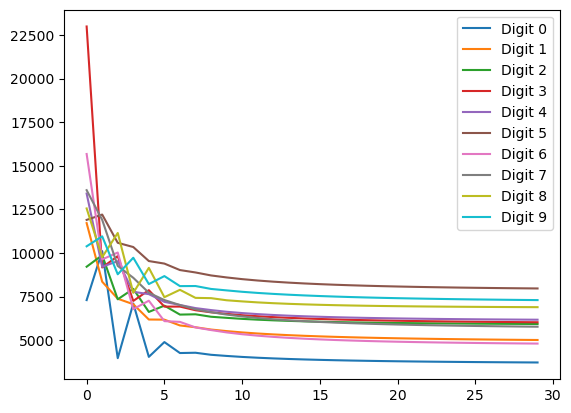

CPU times: user 25.8 s, sys: 8.44 s, total: 34.3 s
Wall time: 24.1 s


In [52]:
%%time
logistic_regression.fit(X_train, y_train)

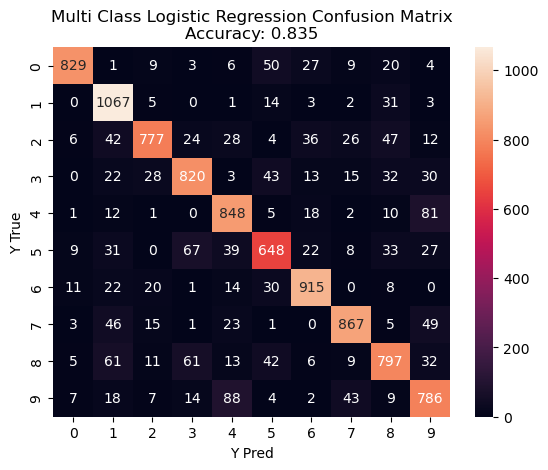

In [53]:
visualize_metrics(-1, X_test, y_test, logistic_regression, 'Logistic Regression')

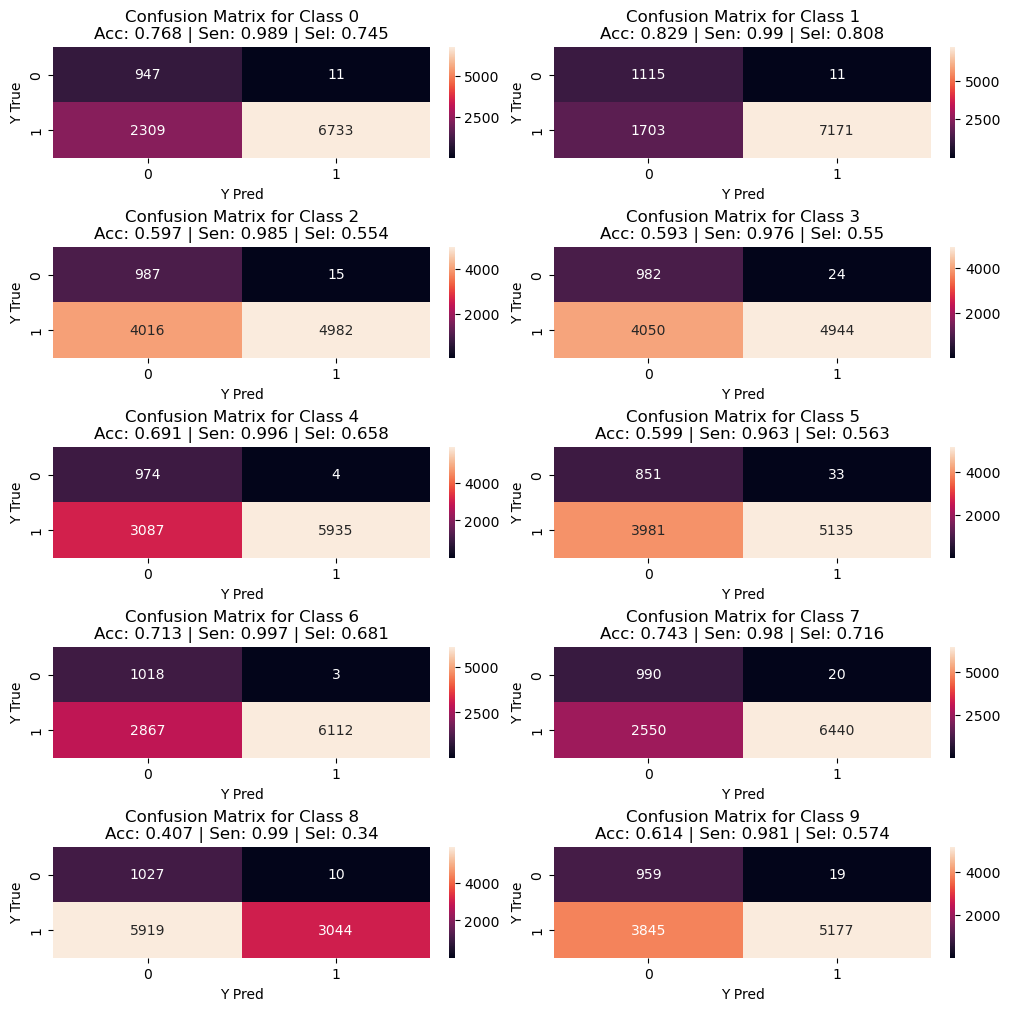

In [54]:
visualize_metrics(0, X_test, y_test, logistic_regression, 'Logistic Regression')

In [30]:
class LinearRegression(BaseRegressor):

    def __init__(self, num_features, classes, learning_rate=0.01, epochs=1):
        super().__init__(num_features, classes, learning_rate, epochs)

    def fit(self, X_train, y_train, visualize=True):
        super().init_multi_class_labels(y_train=y_train, negative_value=0)
        errors = np.zeros(shape=(self.epochs,))
        # getting the rank of the training data matrix
        is_X_train_full_rank = np.linalg.matrix_rank(X_train) == min(X_train.shape[0], X_train.shape[1])
        # if the matrix is full rank we know the solution from the normal equations
        if is_X_train_full_rank:
            self.weights = (self.labels @ X_train) @ np.linalg.inv(X_train.T @ X_train)
            return
        # if it's not full rank, X.T @ X is not an invertible matrix so the weight vector we're looking for is 
        # A @ (X.T @ y) where A = V @ D+ @ V.T where VDV.T is the spectral decomposition of X.T @ X and D+ is 1/D for every [i,i]-th
        # element that's different from 0 and 0 o.w.
        
        # V is the matrix which its' columns are the eigen vectors of X.T @ X
        # we can use the eigh function as X.T @ X is a symmetric matrix so all of its' eigenvalues are real
        eigen_values, V = np.linalg.eigh(X_train.T @ X_train)
        # setting the eigen values in a diagonal matrix
        D = np.diag(eigen_values)
        # preparing the D+ matrix
        D_plus = D
        # setting the inverse of every positive eigen value
        D_plus[D_plus != 0] = 1 / D_plus[D_plus != 0]
        # according to page 125 in "Understanding Machine Learning: From Theory to Algorithms" book, our weight vectors should be 
        # the V @ D+ @ V.T @ X.T @ y, where our y here is the labels
        self.weights = (self.labels @ X_train) @ V @ D_plus @ V.T

    def predict(self, X_test):
        return np.argmax(X_test @ self.weights.T, axis=1)
            

In [31]:
linear_regression = LinearRegression(X.shape[1], np.unique(y))

In [32]:
%%time
linear_regression.fit(X_train, y_train)

CPU times: user 14.1 s, sys: 517 ms, total: 14.6 s
Wall time: 2.65 s


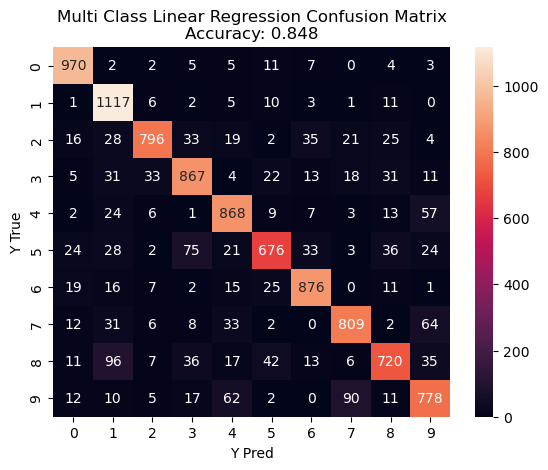

In [33]:
visualize_metrics(-1, X_test, y_test, linear_regression, 'Linear Regression')

In [23]:
# TODO: write comparisons

In [24]:
time.time() - start_notebook_time

67.74500012397766